# Advanced Lane Lines
----

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import random

from PIL import Image
from scipy.stats import linregress

%matplotlib inline

## Helper Functions

Below are some helper functions. Based on the first line lanes project with new functions.
:)

In [2]:
#region of interests
CONST_X_LEFT_TOP = 600
CONST_X_LEFT_BOTTOM = 200
CONST_X_RIGHT_BOTTOM = 150
CONST_Y_TOP = 400
CONST_Y_BOTTOM = 60

def region_of_interest(img, vertices):
    mask = np.zeros_like(img) #defining a blank mask to start with
    
    if len(img.shape) > 2: #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color) #filling pixels inside the polygon with the fill color    
    return cv2.bitwise_and(img, mask)

def vertices_to_crop(img):
    imshape = img.shape
    left_top = (CONST_X_LEFT_TOP,CONST_Y_TOP)
    left_bot = (CONST_X_LEFT_BOTTOM, imshape[0] - CONST_Y_BOTTOM)
    right_top = ((imshape[1]-CONST_X_LEFT_TOP), CONST_Y_TOP)
    right_bot = ((imshape[1]-CONST_X_RIGHT_BOTTOM), imshape[0]-CONST_Y_BOTTOM)
    vertices = np.array([[left_bot, left_top, right_top, right_bot]], dtype=np.int32)
    return vertices

print('Region of Interests OK')

Region of Interests OK


In [3]:
#color functions
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def hls_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def binary_s_channel(img, thresh=(90,255)):
    S = img[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

print('Color functions OK')

Color functions OK


In [4]:
#camera calibration functions
CONST_CORNERS_HORIZ = 9
CONST_CORNERS_VERT = 6

def undistort(chess_image, gray_image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_image.shape[::-1], None, None)
    return cv2.undistort(chess_image, mtx, dist, None, mtx)

def camera_calibration(img):
    #TODO: must be implemented
    return NotImplemented

def chessboard(img, corners=(CONST_CORNERS_HORIZ,CONST_CORNERS_VERT)):
    objpoints = []
    imgpoints = []
    objp = np.zeros((corners[0]*corners[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:corners[0], 0:corners[1]].T.reshape(-1,2)

    #find chessboard corners
    gray = grayscale(img)
    ret, chess_corners = cv2.findChessboardCorners(gray, (corners[0], corners[1]), None)

    #if the chessboard was found
    if ret == True:
        imgpoints.append(chess_corners)
        objpoints.append(objp)
        chess_image = cv2.drawChessboardCorners(img, (corners[0], corners[1]), chess_corners, ret)
    else:
        chess_image = None
    
    return ret, chess_image, objpoints, imgpoints

print('Camera calibration functions OK')

Camera calibration functions OK


In [5]:
#canny, gaussian blur, and hough transform
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_lines(img, lines, color=[255,0,0], thickness=10):
    left_line = []
    right_line = []
    middle_x = img.shape[1] / 2
    
    '''
    Calculate slope of points and create the lines
      - Reject points on the left side of the pictures if the slope is negative
      - Reject points on the right side of the pictures if the slope is positive
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0: #right
                #reject entry if slope is positive and (x1 or x2) < (middle of image)
                if x1 > middle_x and x2 > middle_x: 
                    right_line.append([x1,y1]) 
                    right_line.append([x2,y2])
            elif slope < 0: #left
                #reject entry if slope is negative and (x1 or x2) > (middle of image)
                if x1 < middle_x and x1 < middle_x:
                    left_line.append([x1,y1]) 
                    left_line.append([x2,y2])
    
    #plot left line
    ldata = np.array(left_line)
    if len(ldata) > 0:
        lfit = np.polyfit(ldata[:,0], ldata[:,1] , 1)
        l1z = np.poly1d(lfit)

        lx1 = CONST_X_LEFT_BOTTOM
        lx2 = CONST_X_LEFT_TOP
        cv2.line(img, (lx1, int(l1z(lx1))), (lx2, int(l1z(lx2))), color, thickness, 4)
    
    #plot right line
    rdata = np.array(right_line)
    if len(rdata) > 0:
        rfit = np.polyfit(rdata[:,0], rdata[:,1] ,1)
        r1z = np.poly1d(rfit)

        rx1 = img.shape[1] - CONST_X_RIGHT_BOTTOM
        rx2 = img.shape[1] - CONST_X_LEFT_TOP
        cv2.line(img, (rx1, int(r1z(rx1))), (rx2, int(r1z(rx2))), color, thickness, 4)

def hough_lines(base_img, canny_img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((canny_img.shape[0], canny_img.shape[1], 3), dtype=np.uint8)
    draw_lines(base_img, lines)
    return base_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.4, β=0.6, λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

print('Hough functions OK')

Hough functions OK


In [6]:
#process image (hough)
def process_image(image):
    gray = grayscale(image)
    base_image = np.copy(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 

    # This time we are defining a four sided polygon to mask
    vertices = vertices_to_crop(image)
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 15 # minimum number of pixels making up a line
    max_line_gap = 10 # maximum gap in pixels between connectable line segments    
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    
    hough_image = hough_lines(image, masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
        
    # Draw the lines on the edge image
    w_image = weighted_img(hough_image, base_image)
    
    return w_image

print('Process images OK')

Process images OK


## Calibration Images

camera_cal/calibration2.jpg


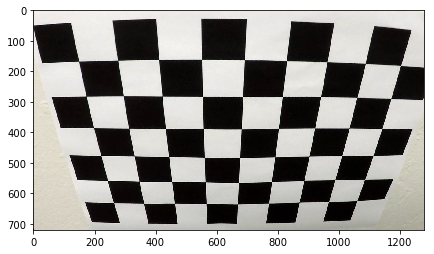

In [7]:
img_index = random.randint(1,20)
img_name = 'camera_cal/calibration' + str(2) + '.jpg' #img_index
print(img_name)

cal_image = mpimg.imread(img_name)
plt.figure(figsize=(7,7))
plt.imshow(cal_image)

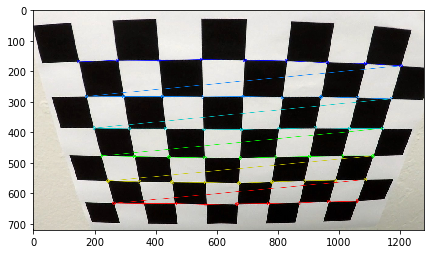

In [8]:
ret, chess_image, objpoints, imgpoints = chessboard(cal_image)

if ret == False:
    print('Different number of corners!')
    ret, chess_image, objpoints, imgpoints = chessboard(cal_image, [9, 5])

#plot image
if ret == True:
    plt.figure(figsize=(7,7))
    plt.imshow(chess_image)
else:
    print('Corners not found!')

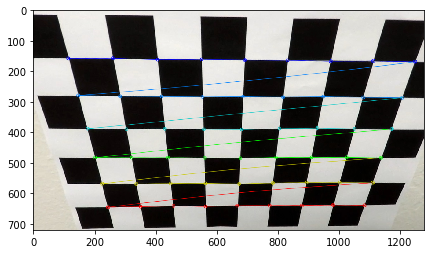

In [9]:
gray_img = grayscale(cal_image)
if ret == True:
    gray_img = grayscale(cal_image)
    undist_img = undistort(chess_image, gray_img, objpoints, imgpoints)
    
    #plot image
    plt.figure(figsize=(7,7))
    plt.imshow(undist_img)
else:
    print('Corners not found!')

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

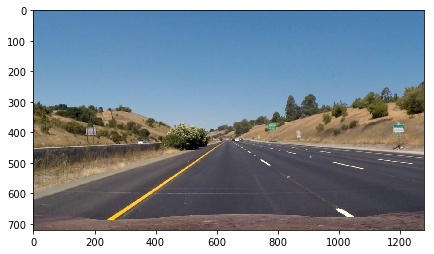

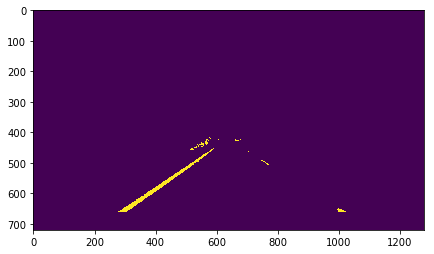

In [13]:
image = mpimg.imread('test_images/straight_lines1.jpg')
hsv_img = hls_color(image) #convert to HSV color

vertices = vertices_to_crop(hsv_img) #define region of interests
masked_edges = region_of_interest(hsv_img, vertices)

s_img = binary_s_channel(masked_edges) #process s channel

#print images
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.figure(figsize=(7,7))
plt.imshow(s_img)

## Test Images Directory



In [ ]:
CONST_INPUT_IMAGES_PATH = "test_images/"
CONST_OUTPUT_IMAGES_PATH = "output_images/"

img_paths = os.listdir(CONST_INPUT_IMAGES_PATH)

for img_name in img_paths:
    #img_name = img_paths[1]
    image = mpimg.imread(CONST_INPUT_IMAGES_PATH + img_name)
    lines_edges = binary_s_channel(region_of_interest(hls_color(image), vertices))
    plt.imshow(lines_edges)
    plt.savefig(CONST_OUTPUT_IMAGES_PATH + img_name)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

Provided videos: `project_video.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Let's try the one with the solid white lane on the right first ...

In [ ]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

video_output = 'output_project_video.mp4'

clip1 = VideoFileClip("project_video.mp4").subclip(1,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Challenge the others videos.
`challenge_video.mp4`
`hard_challenge_video.mp4`